Loading and preprocessing 2400 trials...
Data shape: (2400, 2250, 8)

===== Evaluating Time Windows =====
Testing durations: [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0]
Testing start points: [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5 7.  7.5 8.  8.5]

----- Duration: 0.5s -----
Window 0.0-0.5s | Accuracy: 0.5175 ± 0.0064
Window 0.5-1.0s | Accuracy: 0.5096 ± 0.0072
Window 1.0-1.5s | Accuracy: 0.5137 ± 0.0064
Window 1.5-2.0s | Accuracy: 0.4904 ± 0.0136
Window 2.0-2.5s | Accuracy: 0.4971 ± 0.0048
Window 2.5-3.0s | Accuracy: 0.4987 ± 0.0091
Window 3.0-3.5s | Accuracy: 0.4700 ± 0.0114
Window 3.5-4.0s | Accuracy: 0.5121 ± 0.0127
Window 4.0-4.5s | Accuracy: 0.5029 ± 0.0056
Window 4.5-5.0s | Accuracy: 0.5283 ± 0.0060
Window 5.0-5.5s | Accuracy: 0.5067 ± 0.0012
Window 5.5-6.0s | Accuracy: 0.5175 ± 0.0071
Window 6.0-6.5s | Accuracy: 0.5225 ± 0.0071
Window 6.5-7.0s | Accuracy: 0.4833 ± 0.0156
Window 7.0-7.5s | Accuracy: 0.5304 ± 0.0016


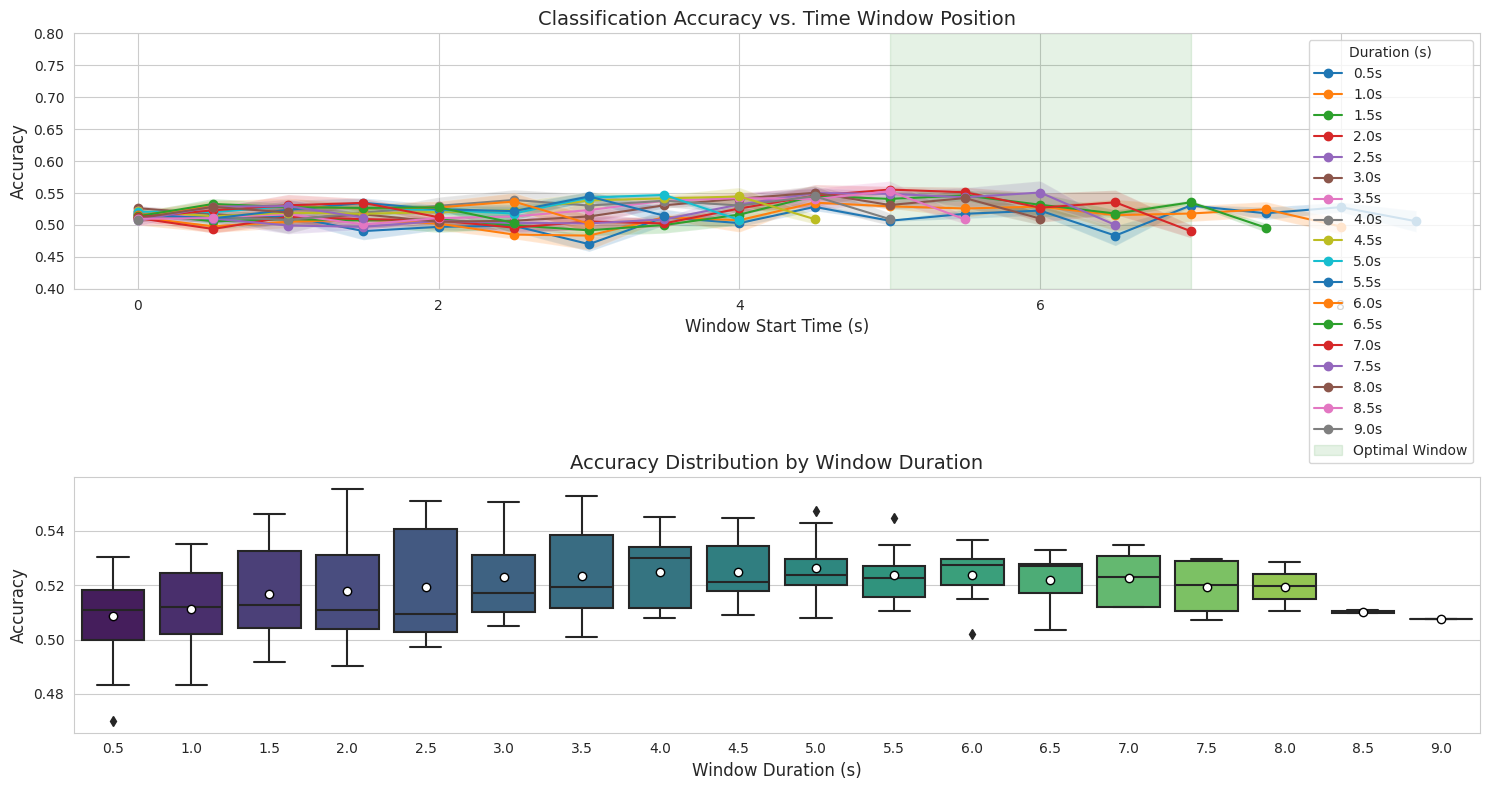

Results saved to time_window_results.csv
CPU times: user 1h 32min 48s, sys: 49.7 s, total: 1h 33min 38s
Wall time: 1h 34min 36s


In [1]:
%%time
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, StratifiedKFold
from scipy.signal import butter, filtfilt, welch
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings('ignore')

# Configuration
BASE_PATH = '/kaggle/input/mtcaic3'
TASK = 'MI'  # Focus on Motor Imagery
SUBSET_SIZE = 4800  # Reduced for faster computation
N_JOBS = -1  # Use all available cores
RANDOM_STATE = 42
CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']  # All 8 EEG channels
FS = 250  # Sampling rate

# Load training metadata
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
mi_train = train_df[train_df['task'] == TASK].copy()
mi_train = mi_train.iloc[:SUBSET_SIZE]  # Use subset for faster computation

# Bandpass filter function (8-30 Hz)
def butter_bandpass_filter(data, lowcut=8, highcut=30, fs=250, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

# Function to load and preprocess trial data
def load_and_filter_trial(row):
    # Construct file path
    eeg_path = os.path.join(
        BASE_PATH, 
        row['task'], 
        'train',
        row['subject_id'],
        str(row['trial_session']),
        'EEGdata.csv'
    )
    
    # Load EEG data
    eeg_data = pd.read_csv(eeg_path)
    
    # Extract specific trial
    start_idx = (row['trial'] - 1) * 2250
    end_idx = start_idx + 2250
    trial_data = eeg_data.iloc[start_idx:end_idx]
    
    # Filter data and convert to float64
    filtered_data = np.zeros((2250, len(CHANNELS)), dtype=np.float64)
    for i, ch in enumerate(CHANNELS):
        filtered_data[:, i] = butter_bandpass_filter(trial_data[ch].values.astype(np.float64))
    
    return filtered_data

# Prepare data storage
X_full = []
y_full = []
print(f"Loading and preprocessing {len(mi_train)} trials...")

for _, row in mi_train.iterrows():
    X_full.append(load_and_filter_trial(row))
    y_full.append(row['label'])
    
X_full = np.array(X_full)
y_full = np.array(y_full)
print("Data shape:", X_full.shape)  # Should be (n_trials, 2250, 8)

# Enhanced feature extraction
def extract_features(X_window):
    n_trials, n_times, n_channels = X_window.shape
    features = []
    
    for trial in X_window:
        trial_features = []
        
        # Time-domain features for all channels
        for channel in range(n_channels):
            # Basic statistics
            mean = np.mean(trial[:, channel])
            std = np.std(trial[:, channel])
            var = np.var(trial[:, channel])
            
            # Higher-order statistics
            sk = skew(trial[:, channel])
            kurt = kurtosis(trial[:, channel])
            
            # Hjorth parameters
            diff1 = np.diff(trial[:, channel])
            mobility = np.sqrt(np.var(diff1) / var)
            diff2 = np.diff(diff1)
            complexity = np.sqrt(np.var(diff2) / np.var(diff1)) / mobility
            
            trial_features.extend([mean, std, var, sk, kurt, mobility, complexity])
        
        # Frequency-domain features for key channels
        key_channels = [CHANNELS.index('C3'), CHANNELS.index('C4')]
        for channel in key_channels:
            freqs, psd = welch(trial[:, channel], fs=FS, nperseg=128)
            
            # Band power features
            bands = {
                'delta': (1, 4),
                'theta': (4, 8),
                'alpha': (8, 13),
                'beta': (13, 30),
                'gamma': (30, 45)
            }
            
            for band, (low, high) in bands.items():
                band_mask = np.logical_and(freqs >= low, freqs <= high)
                band_power = np.sum(psd[band_mask])
                trial_features.append(np.log(band_power + 1e-10))  # Log transform with epsilon
            
            # Power ratios
            alpha_mask = np.logical_and(freqs >= 8, freqs <= 13)
            beta_mask = np.logical_and(freqs >= 13, freqs <= 30)
            alpha_power = np.sum(psd[alpha_mask])
            beta_power = np.sum(psd[beta_mask])
            alpha_beta_ratio = alpha_power / (beta_power + 1e-10)
            trial_features.append(np.log(alpha_beta_ratio + 1e-10))
        
        # Add asymmetry features
        if CHANNELS.index('C3') in key_channels and CHANNELS.index('C4') in key_channels:
            # Get band powers for asymmetry calculation
            _, psd_c3 = welch(trial[:, CHANNELS.index('C3')], fs=FS, nperseg=128)
            _, psd_c4 = welch(trial[:, CHANNELS.index('C4')], fs=FS, nperseg=128)
            
            # Mu band asymmetry
            mu_mask = np.logical_and(freqs >= 8, freqs <= 13)
            c3_mu = np.sum(psd_c3[mu_mask])
            c4_mu = np.sum(psd_c4[mu_mask])
            mu_asymmetry = np.log(c4_mu + 1e-10) - np.log(c3_mu + 1e-10)
            trial_features.append(mu_asymmetry)
            
            # Beta band asymmetry
            beta_mask = np.logical_and(freqs >= 13, freqs <= 30)
            c3_beta = np.sum(psd_c3[beta_mask])
            c4_beta = np.sum(psd_c4[beta_mask])
            beta_asymmetry = np.log(c4_beta + 1e-10) - np.log(c3_beta + 1e-10)
            trial_features.append(beta_asymmetry)
        
        features.append(trial_features)
    
    return np.array(features)

# Time window analysis function
def evaluate_time_windows(X, y, window_starts, window_duration, cv_splits=3):
    results = []
    max_time = X.shape[1] / FS  # 9.0 seconds
    
    for start in window_starts:
        end_time = start + window_duration
        
        # Skip windows that exceed trial length
        if end_time > max_time:
            continue
            
        # Calculate sample indices
        start_sample = int(start * FS)
        end_sample = start_sample + int(window_duration * FS)
        
        # Extract time window
        X_window = X[:, start_sample:end_sample, :]
        
        # Extract features
        X_features = extract_features(X_window)
        
        # Create classifier
        clf = LinearDiscriminantAnalysis()
        
        # Cross-validation
        cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_STATE)
        try:
            scores = cross_val_score(clf, X_features, y, cv=cv, n_jobs=N_JOBS)
            mean_acc = np.mean(scores)
            std_acc = np.std(scores)
        except Exception as e:
            continue
        
        # Store results
        results.append({
            'start': start,
            'duration': window_duration,
            'mean_accuracy': mean_acc,
            'std_accuracy': std_acc,
            'end': end_time
        })
        
        print(f"Window {start:.1f}-{end_time:.1f}s | "
              f"Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
    
    return pd.DataFrame(results)

# Define time windows to evaluate
window_starts = np.arange(0.0, 9.0, 0.5)
window_durations = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0]# Evaluate all combinations
all_results = []
print("\n===== Evaluating Time Windows =====")
print(f"Testing durations: {window_durations}")
print(f"Testing start points: {window_starts}")

for duration in window_durations:
    print(f"\n----- Duration: {duration}s -----")
    df_results = evaluate_time_windows(X_full, y_full, window_starts, duration)
    if not df_results.empty:
        all_results.append(df_results)
    
if all_results:
    results_df = pd.concat(all_results, ignore_index=True)
    
    # Find best performing window
    best_idx = results_df['mean_accuracy'].idxmax()
    best_window = results_df.loc[best_idx]
    print("\n===== Best Window =====")
    # Ensure we're printing scalar values
    start_val = best_window['start']
    duration_val = best_window['duration']
    mean_acc_val = best_window['mean_accuracy']
    std_acc_val = best_window['std_accuracy']
    
    print(f"Start: {start_val:.1f}s, Duration: {duration_val:.1f}s")
    print(f"Accuracy: {mean_acc_val:.4f} ± {std_acc_val:.4f}")

    # Visualization
    plt.figure(figsize=(15, 8))
    sns.set_style("whitegrid")

    # Accuracy vs. Window Position
    plt.subplot(2, 1, 1)
    for duration in window_durations:
        subset = results_df[results_df['duration'] == duration]
        plt.plot(subset['start'], subset['mean_accuracy'], 'o-', label=f'{duration}s')
        plt.fill_between(
            subset['start'],
            subset['mean_accuracy'] - subset['std_accuracy'],
            subset['mean_accuracy'] + subset['std_accuracy'],
            alpha=0.2
        )
    
    # Highlight best window
    plt.axvspan(best_window['start'], best_window['end'], color='green', alpha=0.1, label='Optimal Window')
    plt.title('Classification Accuracy vs. Time Window Position', fontsize=14)
    plt.xlabel('Window Start Time (s)', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(title='Duration (s)')
    plt.ylim(0.4, 0.8)

    # Duration Comparison
    plt.subplot(2, 1, 2)
    sns.boxplot(
        data=results_df, 
        x='duration', 
        y='mean_accuracy',
        palette='viridis',
        showmeans=True,
        meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black'}
    )
    plt.title('Accuracy Distribution by Window Duration', fontsize=14)
    plt.xlabel('Window Duration (s)', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.tight_layout()
    plt.savefig('time_window_analysis.png', dpi=300)
    plt.show()

    # Save results
    results_df.to_csv('time_window_results.csv', index=False)
    print("Results saved to time_window_results.csv")
else:
    print("No valid results were generated")